## Import delle librerie

In [21]:
import json
import os
import torch
import random
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT

import torch
from tqdm import tqdm
from pprint import PrettyPrinter
from torch import nn
import torchvision

import json
import random
from collections import defaultdict

import sys

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as FT

import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import random

## Path

In [8]:
# path del dataset
base_dict = '/kaggle/input/our-xview-dataset'

# path della cartella contenente le immagini
img_dict = '/kaggle/input/our-xview-dataset/images'

# path di output
output_folder = '/kaggle/working/'

# path contenente le annotazioni in formato .json
coco_json_path = os.path.join(base_dict, 'COCO_annotations_new.json') 
new_coco_json_path = os.path.join(output_folder, 'mod_COCO_annotations.json') 

# path file per il training
train_image = os.path.join(output_folder, 'TRAIN_images.json')
train_bbox = os.path.join(output_folder, 'TRAIN_objects.json')

# path file per la validation
val_image = os.path.join(output_folder, 'VAL_images.json')
val_bbox = os.path.join(output_folder, 'VAL_objects.json')

# path file per il test
test_image = os.path.join(output_folder, 'TEST_images.json')
test_bbox = os.path.join(output_folder, 'TEST_objects.json')

checkpoint_path = '/kaggle/input/ssd_checkpoint/pytorch/ssd/3/checkpoint_ssd300.pth.tar'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# COCO Preprocessing

In [4]:
def process_custom_coco_json(input_path, output_path):
    """
    Funzione per processare un JSON COCO in formato personalizzato.
    """
    # Leggi il JSON dal file di input
    data = load_json(input_path)

    # Ottieni e correggi il formato delle categorie
    raw_categories = data.get('categories', [])
    categories = []
 
    for category in tqdm(raw_categories, desc="Processing Categories"):
        for id_str, name in category.items():
            try:
                categories.append({"id": int(id_str), "name": name})
            except ValueError:
                print(f"Errore nel parsing della categoria: {category}")
 
    # Trova la categoria "Aircraft" con ID 0
    aircraft_category = next((cat for cat in categories if cat['id'] == 0 and cat['name'] == "Aircraft"), None)
    if aircraft_category:
        aircraft_category['id'] = 11  # Cambia l'ID della categoria "Aircraft" a 11
 
    # Aggiungi la categoria "background" con ID 0 se non esiste
    if not any(cat['id'] == 0 for cat in categories):
        categories.append({"id": 0, "name": "background"})
 
    # Preprocessa le annotazioni in un dizionario per immagini
    image_annotations_dict = {}
    for annotation in tqdm(data.get('annotations', []), desc="Building Image Annotations Dictionary"):
        image_id = annotation['image_id']
        if image_id not in image_annotations_dict:
            image_annotations_dict[image_id] = []
        image_annotations_dict[image_id].append(annotation)
 
    # Elenco di annotazioni da mantenere (solo quelle valide)
    valid_annotations = []
    annotations_to_remove = set()
 
    # Controllo dei bounding box
    for annotation in tqdm(data.get('annotations', []), desc="Processing Annotations"):
        if annotation['category_id'] == 0:  # Se è Aircraft
            annotation['category_id'] = 11
        
        # Converte il formato del bbox
        if isinstance(annotation['bbox'], str):
            annotation['bbox'] = json.loads(annotation['bbox'])
        
        x, y, width, height = annotation['bbox']
        xmin, xmax = x, x + width
        ymin, ymax = y, y + height
        
        # Verifica che xmin < xmax e ymin < ymax, e che la larghezza e altezza siano sufficienti
        if xmin >= xmax or ymin >= ymax or width <= 10 or height <= 10:
            annotations_to_remove.add(annotation['id'])
        else:
            annotation['bbox'] = [xmin, ymin, xmax, ymax]
            valid_annotations.append(annotation)
 
    # Rimuovi le annotazioni non valide
    data['annotations'] = valid_annotations
 
    # Verifica se ci sono immagini senza annotazioni (usando il dizionario delle annotazioni)
    new_annotations = []
    for image in tqdm(data.get('images', []), desc="Processing Images"):
        if image['id'] not in image_annotations_dict:  # Se l'immagine non ha annotazioni
            # Aggiungi la categoria "background"
            new_annotation = {
                'id': len(data['annotations']) + len(new_annotations),
                'image_id': image['id'],
                'category_id': 0,  # Categoria background con ID 0
                'area': image['width'] * image['height'],
                'bbox': [0.0, 0.0, image['width'], image['height']],  # Background con bbox che copre tutta l'immagine
                'iscrowd': 0
            }
            new_annotations.append(new_annotation)
 
    # Aggiungi le nuove annotazioni al JSON originale
    data['annotations'].extend(new_annotations)
 
    # Aggiorna le categorie nel JSON
    data['categories'] = categories
 
    # Scrivi il JSON modificato nel file di output
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)

In [30]:
def visualize_coco_samples(json_path, images_dir, num_samples=4, label_map=None):
    """
    Visualizza immagini con bounding boxes e label da un dataset COCO personalizzato.
    
    :param json_path: Path al file JSON in formato COCO.
    :param images_dir: Directory che contiene le immagini.
    :param num_samples: Numero di immagini da visualizzare.
    :param label_map: Dizionario per mappare gli ID delle categorie ai nomi delle classi.
    """
    # Carica il file JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Crea un dizionario di annotazioni per immagine
    annotations_dict = {}
    for annotation in data['annotations']:
        image_id = annotation['image_id']
        if image_id not in annotations_dict:
            annotations_dict[image_id] = []
        annotations_dict[image_id].append(annotation)
    
    # Campiona immagini casuali
    sampled_images = random.sample(data['images'], num_samples)
    
    # Imposta la visualizzazione
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5 * num_samples))
    if num_samples == 1:  # Se c'è solo un esempio, assicura che axes sia iterabile
        axes = [axes]
    
    for i, image_meta in enumerate(sampled_images):
        image_id = image_meta['id']
        file_name = image_meta['file_name']
        img_path = f"{images_dir}/{file_name}"
        
        # Carica l'immagine
        image = Image.open(img_path).convert('RGB')
        
        # Mostra immagine originale
        axes[i][0].imshow(image)
        axes[i][0].set_title(f"Original Image: {file_name}")
        axes[i][0].axis('off')
        
        # Mostra immagine con bounding boxes
        axes[i][1].imshow(image)
        axes[i][1].set_title(f"Image with BBoxes: {file_name}")
        axes[i][1].axis('off')
        
        # Recupera annotazioni
        if image_id in annotations_dict:
            for annotation in annotations_dict[image_id]:
                # Bounding box
                xmin, ymin, xmax, ymax = annotation['bbox']
                width, height = xmax - xmin, ymax - ymin
                
                # Disegna il rettangolo
                rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
                axes[i][1].add_patch(rect)
                
                # Etichetta
                category_id = annotation['category_id']
                label = label_map[category_id] if label_map and category_id in label_map else f"ID: {category_id}"
                axes[i][1].text(xmin, ymin - 10, label, color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

In [5]:
def load_json(file_path):
    """
    Carica un file JSON dal percorso specificato.

    :param file_path: Percorso al file JSON da caricare.
    :return: Dati contenuti nel file JSON (come dizionario o lista).
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [6]:
process_custom_coco_json(coco_json_path, new_coco_json_path)

Processing Images: 100%|██████████| 45891/45891 [00:00<00:00, 901693.03it/s]


In [10]:
def extract_categories_from_coco_json(json_path):
    """
    Estrae i nomi delle categorie da un file JSON in formato COCO.

    Args:
        json_path (str): Path del file JSON COCO.

    Returns:
        list: Lista di nomi delle categorie ordinate.
    """
    # Leggi il file JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni i nomi delle categorie
    categories = [cat["name"] for cat in data.get('categories', [])]
    
    # Ordina i nomi delle categorie
    categories = sorted(categories)
    
    # Aggiungi una categoria "background" come primo elemento se non esiste
    if "background" not in categories:
        categories.insert(0, "background")
    
    return categories

# Estrai i nomi delle categorie
categories = extract_categories_from_coco_json(new_coco_json_path)

In [11]:
# Mostra i nomi delle categorie
print(categories)

# Creazione del label map e reverse label map
label_map = {idx: category for idx, category in enumerate(categories)}
rev_label_map = {category: idx for idx, category in enumerate(categories)}

['Aircraft', 'Building', 'Engineering Vehicle', 'Helipad', 'Maritime Vessel', 'Passenger Vehicle', 'Pylon', 'Railway Vehicle', 'Shipping Container', 'Storage Tank', 'Truck', 'background']


ValueError: too many values to unpack (expected 4)

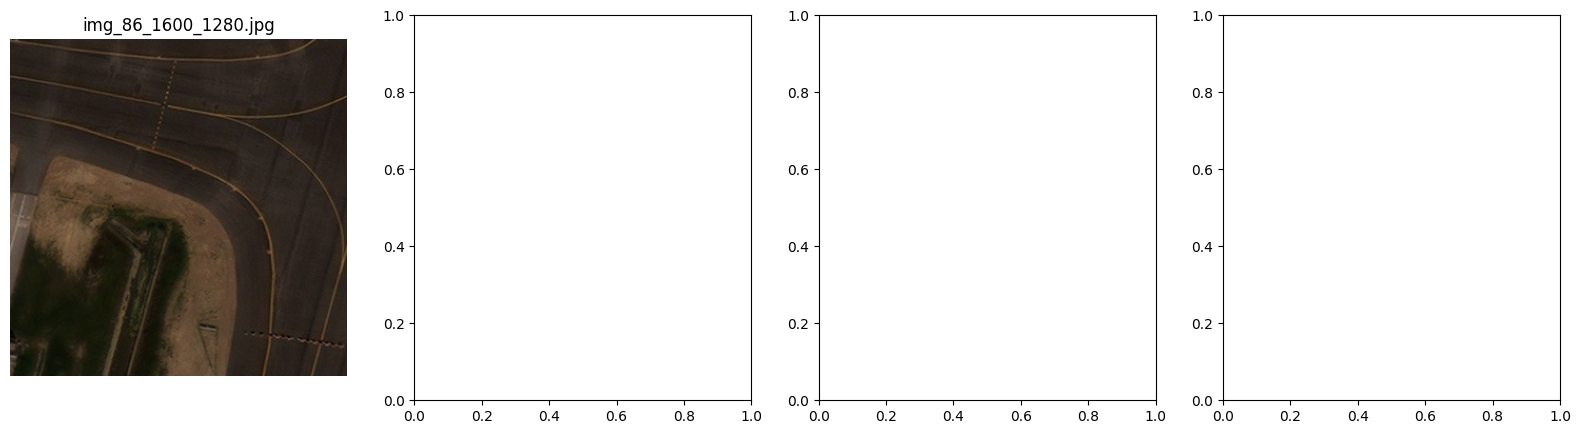

In [28]:
visualize_coco_samples(
    json_path=coco_json_path,
    images_dir=img_dict,
    num_samples=4,
    label_map=label_map
)

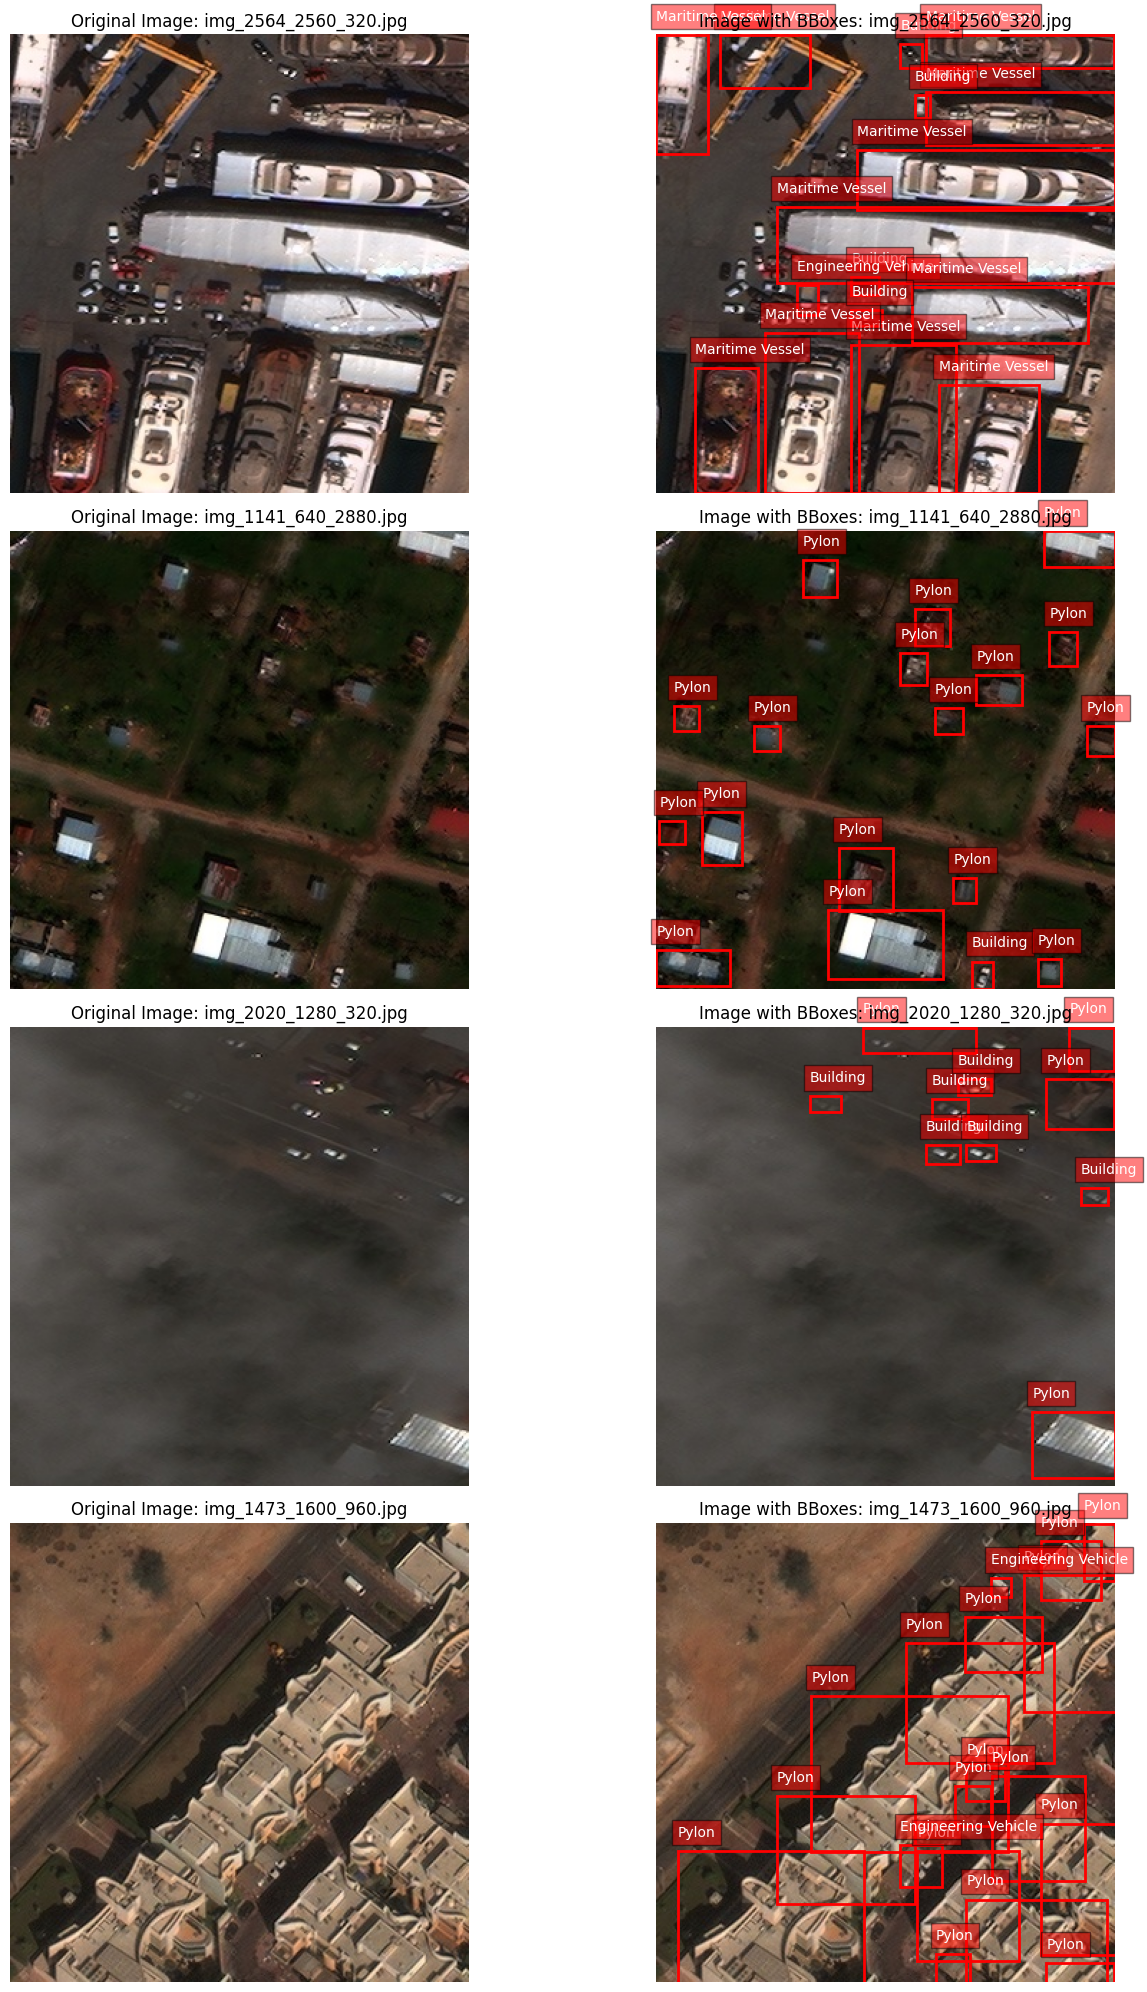

In [31]:
visualize_coco_samples(
    json_path=new_coco_json_path,
    images_dir=img_dict,
    num_samples=4,
    label_map=label_map
)

# Splitting

In [12]:
def split_coco_and_check(coco_file, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1): #modifica in modo da fare lo split solo train e test
    # Carica il file COCO
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)

    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = coco_data['categories']

    total_images = len(images)
    total_annotations = len(annotations)

    # Shuffle delle immagini per garantire casualità
    random.shuffle(images)

    # Calcola i numeri di immagini per train, val e test
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)
    test_count = total_images - train_count - val_count

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Crea set di ID immagini
    train_ids = {img['id'] for img in train_images}
    val_ids = {img['id'] for img in val_images}
    test_ids = {img['id'] for img in test_images}

    # Divide le annotazioni
    train_annotations = [ann for ann in annotations if ann['image_id'] in train_ids]
    val_annotations = [ann for ann in annotations if ann['image_id'] in val_ids]
    test_annotations = [ann for ann in annotations if ann['image_id'] in test_ids]

    train_bbox_count = len(train_annotations)
    val_bbox_count = len(val_annotations)
    test_bbox_count = len(test_annotations)

    # Salva i file di output
    def save_split(file_name, images_split):
        with open(file_name, 'w') as f:
            for img in images_split:
                f.write(f"{output_path}/{img['file_name']}\n")

    save_split('train.txt', train_images)
    save_split('val.txt', val_images)
    save_split('test.txt', test_images)

    # Controlla le proporzioni
    check_split_proportions(
        total_images, total_annotations,
        len(train_images), len(val_images), len(test_images),
        train_bbox_count, val_bbox_count, test_bbox_count,
        train_ratio, val_ratio, test_ratio,
        train_annotations, val_annotations, test_annotations,
        categories
    )

def check_split_proportions(total_images, total_annotations, train_count, val_count, test_count, 
                            train_bbox_count, val_bbox_count, test_bbox_count, 
                            train_ratio, val_ratio, test_ratio, 
                            train_annotations, val_annotations, test_annotations, categories):
    # Percentuali per immagini
    train_image_percentage = (train_count / total_images) * 100
    val_image_percentage = (val_count / total_images) * 100
    test_image_percentage = (test_count / total_images) * 100

    # Percentuali per bbox
    train_bbox_percentage = (train_bbox_count / total_annotations) * 100
    val_bbox_percentage = (val_bbox_count / total_annotations) * 100
    test_bbox_percentage = (test_bbox_count / total_annotations) * 100

    print(f"Totale immagini: {total_images}")
    print(f"Totale annotazioni (bbox): {total_annotations}")
    print(f"Train: {train_count} immagini ({train_image_percentage:.2f}%) ({train_bbox_count} bbox) ({train_bbox_percentage:.2f}%)")
    print(f"Val: {val_count} immagini ({val_image_percentage:.2f}%) ({val_bbox_count} bbox) ({val_bbox_percentage:.2f}%)")
    print(f"Test: {test_count} immagini ({test_image_percentage:.2f}%) ({test_bbox_count} bbox) ({test_bbox_percentage:.2f}%)")

    # Calcola il numero di annotazioni per categoria nei vari set
    category_count_train = defaultdict(int)
    category_count_val = defaultdict(int)
    category_count_test = defaultdict(int)

    for annotation in train_annotations:
        category_count_train[annotation['category_id']] += 1
    for annotation in val_annotations:
        category_count_val[annotation['category_id']] += 1
    for annotation in test_annotations:
        category_count_test[annotation['category_id']] += 1

    # Stampa le proporzioni per categoria
    print("\nProporzioni per categoria:")
    for category in categories:
        category_id = category['id']
        category_name = category['name']

        # Conta il numero di annotazioni per categoria in ogni set
        train_cat_count = category_count_train.get(category_id, 0)
        val_cat_count = category_count_val.get(category_id, 0)
        test_cat_count = category_count_test.get(category_id, 0)

        # Calcola la percentuale di annotazioni per categoria
        total_cat_annotations = train_cat_count + val_cat_count + test_cat_count
        if total_cat_annotations > 0:
            train_cat_percentage = (train_cat_count / total_cat_annotations) * 100
            val_cat_percentage = (val_cat_count / total_cat_annotations) * 100
            test_cat_percentage = (test_cat_count / total_cat_annotations) * 100
        else:
            train_cat_percentage = val_cat_percentage = test_cat_percentage = 0.0

        print(f"{category_name}:")
        print(f"  Train: {train_cat_count} annotazioni ({train_cat_percentage:.2f}%)")
        print(f"  Val: {val_cat_count} annotazioni ({val_cat_percentage:.2f}%)")
        print(f"  Test: {test_cat_count} annotazioni ({test_cat_percentage:.2f}%)")

In [13]:
split_coco_and_check(new_coco_json_path, img_dict, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

Totale immagini: 45891
Totale annotazioni (bbox): 497406
Train: 27534 immagini (60.00%) (298511 bbox) (60.01%)
Val: 9178 immagini (20.00%) (99801 bbox) (20.06%)
Test: 9179 immagini (20.00%) (100474 bbox) (20.20%)

Proporzioni per categoria:
Aircraft:
  Train: 912 annotazioni (58.42%)
  Val: 340 annotazioni (21.78%)
  Test: 309 annotazioni (19.80%)
Passenger Vehicle:
  Train: 56359 annotazioni (59.94%)
  Val: 19089 annotazioni (20.30%)
  Test: 18585 annotazioni (19.76%)
Truck:
  Train: 14731 annotazioni (59.61%)
  Val: 4688 annotazioni (18.97%)
  Test: 5293 annotazioni (21.42%)
Railway Vehicle:
  Train: 2141 annotazioni (58.01%)
  Val: 945 annotazioni (25.60%)
  Test: 605 annotazioni (16.39%)
Maritime Vessel:
  Train: 2830 annotazioni (54.77%)
  Val: 1081 annotazioni (20.92%)
  Test: 1256 annotazioni (24.31%)
Engineering Vehicle:
  Train: 2891 annotazioni (61.07%)
  Val: 853 annotazioni (18.02%)
  Test: 990 annotazioni (20.91%)
Building:
  Train: 206335 annotazioni (59.95%)
  Val: 68580

# Dataset Preprocessing

In [14]:
def parse_coco_annotation(annotation_data):
    """
    Converti le annotazioni COCO in una struttura utile.
    """
    boxes = []
    labels = []

    for ann in annotation_data:
        category_id = ann['category_id']  # Usa direttamente il category_id come etichetta
        bbox = ann['bbox']  # I bounding box sono già nel formato [xmin, ymin, xmax, ymax]
        xmin, ymin, xmax, ymax = bbox

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(category_id)

    return {'boxes': boxes, 'labels': labels}

def create_coco_data_lists(coco_file, splits_path, output_folder):
    """
    Converte i dati COCO e split in liste per train, val e test.
    """
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)

    # Prepara mappature da immagini e annotazioni
    images = {img['file_name']: img for img in coco_data['images']}  # Mappa file_name -> immagine
    annotations_by_image = defaultdict(list)
    for ann in coco_data['annotations']:
        annotations_by_image[ann['image_id']].append(ann)

    # Genera i dati per ciascuno split
    for split in ['train', 'val', 'test']:
        split_file = os.path.join(splits_path, f"{split}.txt")
        with open(split_file, 'r') as f:
            image_files = [line.strip() for line in f.readlines()]

        image_list = []
        objects_list = []

        for image_file in image_files:
            file_name = os.path.basename(image_file)  # Ottieni solo il nome del file
            if file_name not in images:
                continue

            image_info = images[file_name]
            image_id = image_info['id']
            annotations = annotations_by_image[image_id]
            objects = parse_coco_annotation(annotations)

            if not objects['boxes']:
                continue

            image_list.append(image_file)
            objects_list.append(objects)

        # Salva i risultati
        with open(os.path.join(output_folder, f"{split.upper()}_images.json"), 'w') as j:
            json.dump(image_list, j)
        with open(os.path.join(output_folder, f"{split.upper()}_objects.json"), 'w') as j:
            json.dump(objects_list, j)

In [15]:
create_coco_data_lists(new_coco_json_path, output_folder, output_folder)

## Dataloader

In [34]:
class CustomDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a DataLoader for batching.
    """

    def __init__(self, path_image, path_bbox):
        """
        :param path_image: Path to the JSON file containing image paths.
        :param path_bbox: Path to the JSON file containing bounding boxes and labels.
        """
        # Load data
        with open(path_image, 'r') as j:
            self.images = json.load(j)
        with open(path_bbox, 'r') as j:
            self.objects = json.load(j)

        # Ensure the lengths match
        assert len(self.images) == len(self.objects), "Images and annotations must have the same length."

    def __transform(self, image, boxes, labels):
        """
        Apply transformations to the image, boxes, and labels.
        :param image: A PIL Image.
        :param boxes: Bounding boxes as a tensor of dimensions (n_objects, 4).
        :param labels: Labels as a tensor of dimensions (n_objects).
        :return: Transformed image, boxes, and labels.
        """
        def resize(image, boxes, dims=(300, 300)):
            # Resize image
            new_image = FT.resize(image, dims)

            # Normalize bounding boxes
            old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
            new_boxes = boxes / old_dims  # Percent coordinates
            new_dims = torch.FloatTensor([dims[0], dims[1], dims[0], dims[1]]).unsqueeze(0)
            new_boxes = new_boxes * new_dims

            return new_image, new_boxes

        # ImageNet normalization values
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        # Resize image and normalize boxes
        image, boxes = resize(image, boxes)

        # Convert image to tensor
        image = FT.to_tensor(image)

        # Normalize image
        image = FT.normalize(image, mean=mean, std=std)

        return image, boxes, labels

    def __getitem__(self, idx):
        """
        Retrieve an image and its corresponding objects.
        :param idx: Index of the data point.
        :return: Transformed image, bounding boxes, and labels.
        """
        # Load image
        image = Image.open(self.images[idx]).convert('RGB')

        # Load objects
        objects = self.objects[idx]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)

        # Apply transformations
        image, boxes, labels = self.__transform(image, boxes, labels)

        return image, boxes, labels

    def __len__(self):
        """
        Total number of data points.
        :return: Length of the dataset.
        """
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels.
        """

        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)

        return images, boxes, labels  # tensor (N, 3, 300, 300), 2 lists of N tensors each

    def visualize_samples(self, indices, label_map=None):
        """
        Visualize multiple images with bounding boxes and labels before and after transformation.
    
        :param indices: List of indices of the data points to visualize.
        :param label_map: Optional dictionary to map label indices to class names.
        """
        num_samples = len(indices)
        fig, axes = plt.subplots(num_samples, 2, figsize=(15, 7 * num_samples))
    
        if num_samples == 1:
            axes = [axes]  # Ensure axes is iterable when there's only one sample
    
        for i, idx in enumerate(indices):
            # Load image and objects
            original_image = Image.open(self.images[idx]).convert('RGB')
            objects = self.objects[idx]
            boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
            labels = torch.LongTensor(objects['labels'])  # (n_objects)
    
            # Plot original image with bounding boxes
            axes[i][0].imshow(original_image)
            axes[i][0].set_title(f"Original Image {idx}")
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                rect = patches.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )
                axes[i][0].add_patch(rect)
                label_name = label_map[label.item()] if label_map else str(label.item())
                axes[i][0].text(xmin, ymin, label_name, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    
            # Apply transformations
            transformed_image, transformed_boxes, transformed_labels = self.__transform(original_image, boxes, labels)
            transformed_image = transformed_image.permute(1, 2, 0).numpy()  # Convert to (H, W, C) for plotting
    
            # Denormalize image for visualization
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            transformed_image = std * transformed_image + mean  # Reverse normalization
            transformed_image = (transformed_image * 255).astype(np.uint8)
    
            # Plot transformed image with bounding boxes
            axes[i][1].imshow(transformed_image)
            axes[i][1].set_title(f"Transformed Image {idx}")
            for box, label in zip(transformed_boxes, transformed_labels):
                xmin, ymin, xmax, ymax = box
                rect = patches.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    linewidth=2,
                    edgecolor='g',
                    facecolor='none'
                )
                axes[i][1].add_patch(rect)
                label_name = label_map[label.item()] if label_map else str(label.item())
                axes[i][1].text(xmin, ymin, label_name, color='white', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))
    
        plt.tight_layout()
        plt.show()


In [35]:
train_dataset = CustomDataset(train_image, train_bbox)
val_dataset = CustomDataset(val_image, val_bbox)
test_dataset = CustomDataset(test_image, test_bbox)

# Recupera un campione
image, boxes, labels = train_dataset[0]

# Dimensioni
print("Image shape:", image.shape)  # Torch tensor di dimensione (3, 300, 300)
print("Boxes:", boxes)             # Bounding box normalizzati
print("Labels:", labels)           # Etichette

Image shape: torch.Size([3, 300, 300])
Boxes: tensor([[ 52.5000, 127.5000,  89.0625, 172.5000],
        [ 28.1250, 168.7500,  68.4375, 206.2500],
        [  9.3750, 201.5625,  44.0625, 242.8125],
        [232.5000, 230.6250, 300.0000, 282.1875],
        [216.5625, 159.3750, 295.3125, 227.8125]])
Labels: tensor([6, 6, 6, 6, 6])


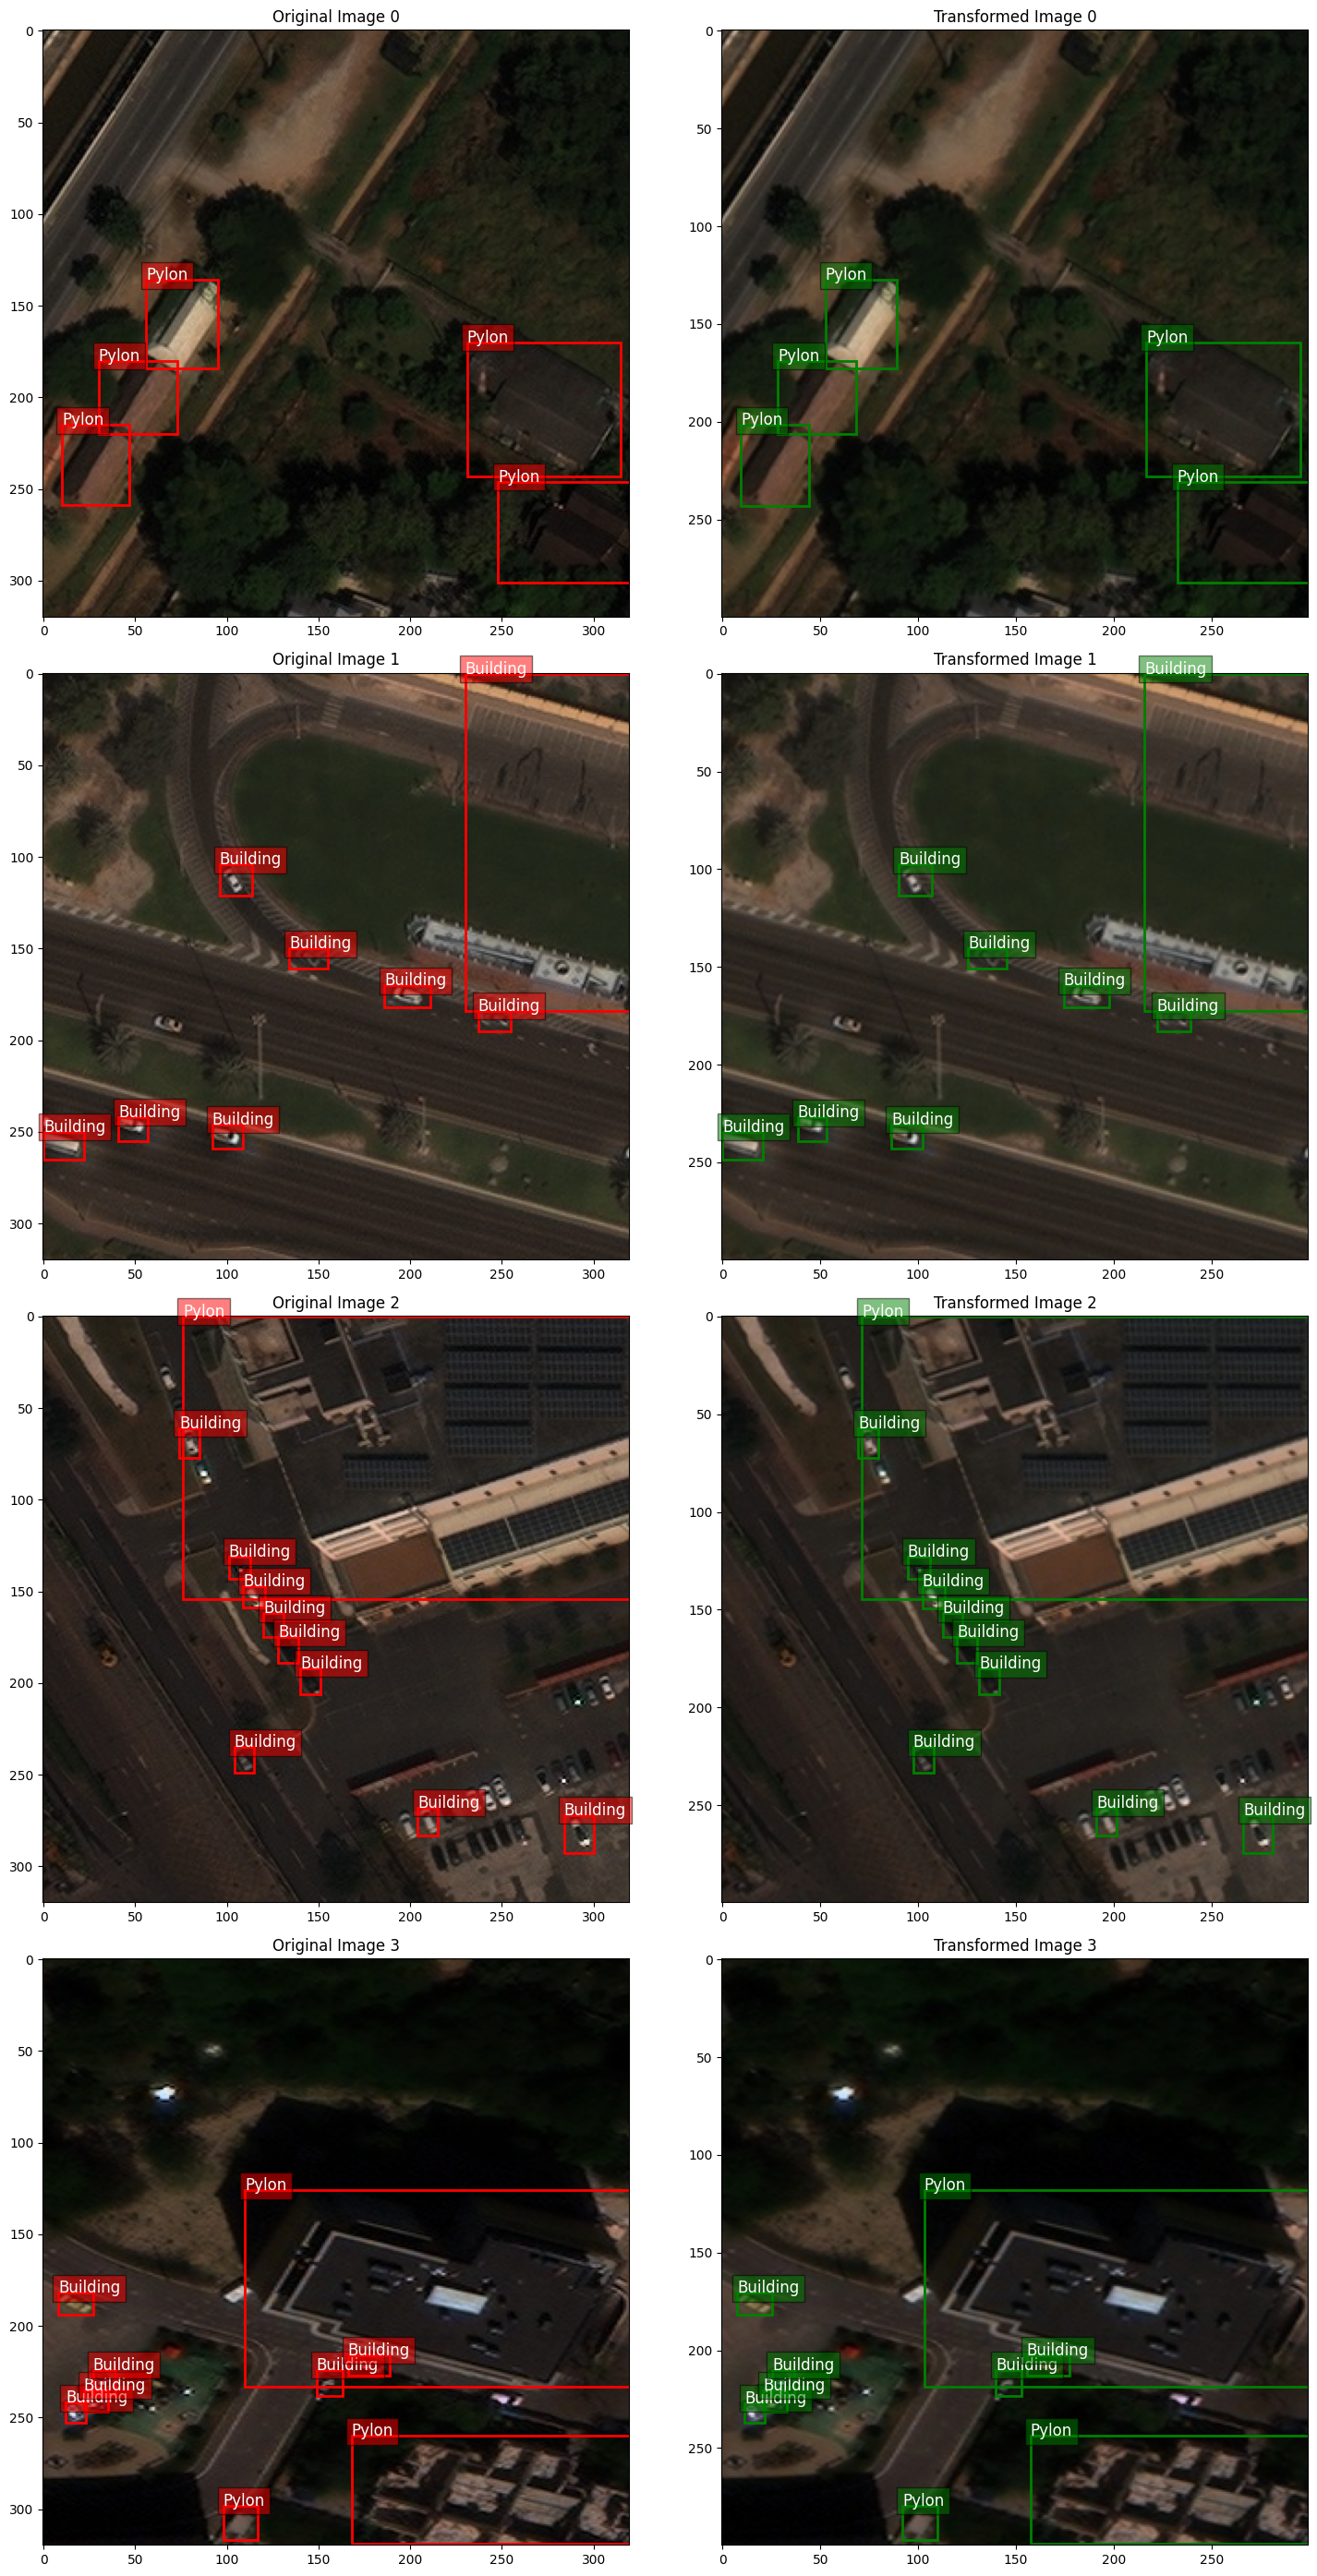

In [36]:
indices = [0, 1, 2, 3]  # Sostituisci con gli indici desiderati
train_dataset.visualize_samples(indices, label_map=label_map)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, 
                                               collate_fn=train_dataset.collate_fn, num_workers=3, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, 
                                             collate_fn=train_dataset.collate_fn, num_workers=3, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, 
                                              collate_fn=train_dataset.collate_fn, num_workers=3, pin_memory=True)

## Model

fare l'import da GitHub https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py

In [14]:
# Aggiungi la directory che contiene 'model.py' alla variabile sys.path
sys.path.append('/kaggle/input/ssd_checkpoint/pytorch/ssd/3')

# Ora importa il modulo 'model' che si trova nella stessa cartella
from model import *  

# Carica il checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu')

/kaggle/input/ssd_checkpoint/pytorch/ssd/3/utils.py:570: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if d.__name__ is 'adjust_hue':
/tmp/ipykernel_23/81667907.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for 

In [15]:
# Verifica le chiavi nel checkpoint (opzionale)
print(checkpoint.keys())

dict_keys(['epoch', 'model'])


In [16]:
# Crea un'istanza del modello
model = SSD300(21)  # Assicurati che la definizione del modello sia corretta

# Carica i pesi nel modello
#model.load_state_dict(checkpoint['model'].state_dict())

# Carica i pesi pre-addestrati per il backbone e altre componenti comuni
pretrained_dict = checkpoint['model'].state_dict()
model_dict = model.state_dict()

# Mantieni solo i pesi che corrispondono tra il modello pre-addestrato e il nuovo
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]  



Loaded base model.



<All keys matched successfully>

## Training

In [17]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)


def adjust_learning_rate(optimizer, scale):
    """
    Scale learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param scale: factor to multiply learning rate with.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * scale
    print("DECAYING learning rate.\n The new LR is %f\n" % (optimizer.param_groups[1]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.

    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)


def save_checkpoint(epoch, model, optimizer):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer}
    filename = 'checkpoint_ssd300.pth.tar'
    torch.save(state, filename)

def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

class Trainer:
    def __init__(self, model, train_dataset, train_dataloader, criterion, optimizer, batch_size, num_workers, device, 
                 grad_clip=None, print_freq=10, iterations=120000, decay_lr_at=None, decay_lr_to=0.1, 
                 momentum=0.9, weight_decay=5e-4):
        """
        Initialize the Trainer.
        
        :param model: SSD300 model instance
        :param train_dataset: Dataset object
        :param criterion: Loss function
        :param optimizer: Optimizer
        :param batch_size: Training batch size
        :param num_workers: Number of data loading workers
        :param device: Device to use for training ('cuda' or 'cpu')
        :param grad_clip: Gradient clipping value (default: None)
        :param print_freq: Frequency of printing training progress
        :param iterations: Total number of training iterations
        :param decay_lr_at: Iterations to decay learning rate
        :param decay_lr_to: Learning rate decay factor
        :param momentum: Momentum for optimizer
        :param weight_decay: Weight decay for optimizer
        """
        self.model = model
        self.train_dataset = train_dataset
        self.criterion = criterion
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.grad_clip = grad_clip
        self.print_freq = print_freq
        self.iterations = iterations
        self.decay_lr_at = decay_lr_at if decay_lr_at is not None else [80000, 100000]
        self.decay_lr_to = decay_lr_to
        self.momentum = momentum
        self.weight_decay = weight_decay

        # Prepare dataloader
        self.train_loader = train_dataloader

        # Calculate epochs and decay epochs
        self.epochs = iterations // (len(train_dataset) // 32)
        self.decay_epochs = [it // (len(train_dataset) // 32) for it in self.decay_lr_at]

    def adjust_learning_rate(self, epoch):
        """
        Adjust the learning rate at specific epochs.
        """
        if epoch in self.decay_epochs:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * self.decay_lr_to
            print(f"Learning rate adjusted to {param_group['lr']} at epoch {epoch}")

    def train_one_epoch(self, epoch):
        """
        Perform one epoch of training.
        """
        self.model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()

        start = time.time()

        for i, (images, boxes, labels) in enumerate(self.train_loader):
            data_time.update(time.time() - start)

            # Move to device
            images = images.to(self.device)
            boxes = [b.to(self.device) for b in boxes]
            labels = [l.to(self.device) for l in labels]

            # Forward pass
            predicted_locs, predicted_scores = self.model(images)

            # Compute loss
            loss = self.criterion(predicted_locs, predicted_scores, boxes, labels)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            if self.grad_clip is not None:
                clip_gradient(self.optimizer, self.grad_clip)

            # Update model parameters
            self.optimizer.step()

            # Update metrics
            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()

            # Print status
            if i % self.print_freq == 0:
                print('Epoch: [{0}][{1}/{2}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(self.train_loader),
                                                                      batch_time=batch_time,
                                                                      data_time=data_time,
                                                                      loss=losses))

        del predicted_locs, predicted_scores, images, boxes, labels

    def save_checkpoint(self, epoch):
        """
        Save model checkpoint.
        """
        torch.save({
            'epoch': epoch,
            'model': self.model,
            'optimizer': self.optimizer,
        }, f'checkpoint_epoch_{epoch}.pth')
        print(f"Checkpoint saved for epoch {epoch}.")

    def train(self, start_epoch=0):
        """
        Train the model across all epochs.
        """
        for epoch in range(start_epoch, self.epochs):
            self.adjust_learning_rate(epoch)
            self.train_one_epoch(epoch)
            self.save_checkpoint(epoch)


In [36]:
from tqdm import tqdm

class Trainer:
    def __init__(self, model, train_dataset, train_dataloader, criterion, optimizer, batch_size, num_workers, device, 
                 grad_clip=None, print_freq=10, iterations=120000, decay_lr_at=None, decay_lr_to=0.1, 
                 momentum=0.9, weight_decay=5e-4):
        """
        Initialize the Trainer.
        
        :param model: SSD300 model instance
        :param train_dataset: Dataset object
        :param criterion: Loss function
        :param optimizer: Optimizer
        :param batch_size: Training batch size
        :param num_workers: Number of data loading workers
        :param device: Device to use for training ('cuda' or 'cpu')
        :param grad_clip: Gradient clipping value (default: None)
        :param print_freq: Frequency of printing training progress
        :param iterations: Total number of training iterations
        :param decay_lr_at: Iterations to decay learning rate
        :param decay_lr_to: Learning rate decay factor
        :param momentum: Momentum for optimizer
        :param weight_decay: Weight decay for optimizer
        """
        self.model = model
        self.train_dataset = train_dataset
        self.criterion = criterion
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.grad_clip = grad_clip
        self.print_freq = print_freq
        self.iterations = iterations
        self.decay_lr_at = decay_lr_at if decay_lr_at is not None else [80000, 100000]
        self.decay_lr_to = decay_lr_to
        self.momentum = momentum
        self.weight_decay = weight_decay

        # Prepare dataloader
        self.train_loader = train_dataloader

        # Calculate epochs and decay epochs
        #self.epochs = iterations // (len(train_dataset) // 32)
        self.epochs = 10
        self.decay_epochs = [it // (len(train_dataset) // 32) for it in self.decay_lr_at]

    def adjust_learning_rate(self, epoch):
        """
        Adjust the learning rate at specific epochs.
        """
        if epoch in self.decay_epochs:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * self.decay_lr_to
            print(f"Learning rate adjusted to {param_group['lr']} at epoch {epoch}")

    def train_one_epoch(self, epoch):
        """
        Perform one epoch of training.
        """
        self.model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()

        start = time.time()

        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch}/{self.epochs}", unit="batch") as pbar:
            for i, (images, boxes, labels) in enumerate(self.train_loader):
                data_time.update(time.time() - start)

                # Move to device
                images = images.to(self.device)
                boxes = [b.to(self.device) for b in boxes]
                labels = [l.to(self.device) for l in labels]

                # Forward pass
                predicted_locs, predicted_scores = self.model(images)

                # Compute loss
                loss = self.criterion(predicted_locs, predicted_scores, boxes, labels)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                if self.grad_clip is not None:
                    clip_gradient(self.optimizer, self.grad_clip)

                # Update model parameters
                self.optimizer.step()

                # Update metrics
                losses.update(loss.item(), images.size(0))
                batch_time.update(time.time() - start)

                # Update progress bar
                pbar.set_postfix({
                    "Batch Time": f"{batch_time.val:.3f}s",
                    "Data Time": f"{data_time.val:.3f}s",
                    "Loss": f"{losses.val:.4f} (avg: {losses.avg:.4f})"
                })
                pbar.update(1)

                start = time.time()

        del predicted_locs, predicted_scores, images, boxes, labels

    def save_checkpoint(self, epoch):
        """
        Save model checkpoint.
        """
        torch.save({
            'epoch': epoch,
            'model': self.model,
            'optimizer': self.optimizer,
        }, f'checkpoint_epoch_{epoch}.pth')
        print(f"Checkpoint saved for epoch {epoch}.")

    def train(self, start_epoch=0):
        """
        Train the model across all epochs.
        """
        for epoch in range(start_epoch, self.epochs):
            self.adjust_learning_rate(epoch)
            self.train_one_epoch(epoch)
            self.save_checkpoint(epoch)


In [37]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.

    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()  # *smooth* L1 loss in the paper; see Remarks section in the tutorial
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

In [38]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [39]:
# Model parameters
n_classes = 12  # number of different types of objects

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 8  # batch size
iterations = 10  # number of iterations to train
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 200  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = 0.8  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation
model = SSD300(n_classes=n_classes)


Loaded base model.



In [40]:
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

# Ottimizzatore
biases = [param for name, param in model.named_parameters() if param.requires_grad and name.endswith('.bias')]
not_biases = [param for name, param in model.named_parameters() if param.requires_grad and not name.endswith('.bias')]
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                            lr=lr, momentum=momentum, weight_decay=weight_decay)


In [41]:
# Configurazione del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

# Preparazione del modello, dataset e dataloader
model = model.to(device)  # Sposta il modello sul dispositivo

Training on cuda


In [ ]:
# Creazione del Trainer
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    train_dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=batch_size,
    num_workers=workers,
    device=device,
    grad_clip=grad_clip
)

# Avvio del training
trainer.train()

## Testing sulle predizioni

In [57]:
class Evaluator:
    def __init__(self, model, test_dataset, label_map, rev_label_map, batch_size, num_workers, device):
        """
        Initialize the Evaluator.
        
        :param model: Trained SSD model to be evaluated
        :param test_dataset: Dataset object for testing
        :param batch_size: Batch size for evaluation
        :param num_workers: Number of data loading workers
        :param device: Device to use for evaluation ('cuda' or 'cpu')
        """
        self.model = model.to(device)
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.pp = PrettyPrinter()  # For printing APs nicely

        # Prepare dataloader
        self.test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=test_dataset.collate_fn,
            num_workers=num_workers,
            pin_memory=True
        )

    self.label_map = label_map
    self.rev_label_map = rev_label_map

    def evaluate(self):
        """
        Perform evaluation and compute mAP.
        """
        self.model.eval()

        # Lists to store detected and true boxes, labels, scores
        det_boxes = list()
        det_labels = list()
        det_scores = list()
        true_boxes = list()
        true_labels = list()

        with torch.no_grad():
            for i, (images, boxes, labels) in enumerate(tqdm(self.test_loader, desc='Evaluating')):
                images = images.to(self.device)

                # Forward pass
                predicted_locs, predicted_scores = self.model(images)

                # Detect objects
                det_boxes_batch, det_labels_batch, det_scores_batch = self.model.detect_objects(
                    predicted_locs, predicted_scores,
                    min_score=0.01, max_overlap=0.45, top_k=200
                )

                # Store this batch's results
                boxes = [b.to(self.device) for b in boxes]
                labels = [l.to(self.device) for l in labels]

                det_boxes.extend(det_boxes_batch)
                det_labels.extend(det_labels_batch)
                det_scores.extend(det_scores_batch)
                true_boxes.extend(boxes)
                true_labels.extend(labels)

        # Visualize Confusion Matrix
        self.plot_confusion_matrix(det_labels, true_labels)

        # Calculate mAP
        APs, mAP = self.calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, self.label_map, self.rev_label_map, self.device)

        # Print AP for each class
        self.pp.pprint(APs)
        print('\nMean Average Precision (mAP): %.3f' % mAP)

        # Visualize Precision-Recall
        self.plot_precision_recall(APs)

    @staticmethod
    def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, label_map, rev_label_map, device):
        """
        Calculate the Mean Average Precision (mAP) of detected objects.
    
        :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
        :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
        :param det_scores: list of tensors, one tensor for each image containing detected objects' scores
        :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
        :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
        :param label_map: Mapping of label indices to human-readable class names
        :param rev_label_map: Reverse mapping from class names to label indices
        :param device: The device (e.g., 'cuda' or 'cpu')
        :return: dictionary of average precisions for all classes, mean average precision (mAP)
        """
        assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(true_labels)
        n_classes = 12
    
        # Store all (true) objects in a single continuous tensor
        true_images = []
        for i in range(len(true_labels)):
            true_images.extend([i] * true_labels[i].size(0))
        true_images = torch.LongTensor(true_images).to(device)  # (n_objects)
        true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
        true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    
        # Store all detections in a single continuous tensor
        det_images = []
        for i in range(len(det_labels)):
            det_images.extend([i] * det_labels[i].size(0))
        det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
        det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
        det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
        det_scores = torch.cat(det_scores, dim=0)  # (n_detections)
    
        # Calculate APs for each class (except background)
        average_precisions = torch.zeros(n_classes - 1, dtype=torch.float).to(device)  # (n_classes - 1)
    
        for c in range(1, n_classes):  # Classes are 1-indexed (background is 0)
            # Extract true objects for class 'c'
            true_class_images = true_images[true_labels == c]  # (n_class_objects)
            true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
            n_easy_class_objects = true_class_boxes.size(0)  # total number of objects for this class
    
            # Track detected objects for class 'c'
            det_class_images = det_images[det_labels == c]  # (n_class_detections)
            det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
            det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
            n_class_detections = det_class_boxes.size(0)
    
            if n_class_detections == 0:
                continue
    
            # Sort detections by score
            det_class_scores, sort_ind = torch.sort(det_class_scores, descending=True)
            det_class_images = det_class_images[sort_ind]
            det_class_boxes = det_class_boxes[sort_ind]
    
            # Initialize true positives and false positives
            true_positives = torch.zeros(n_class_detections, dtype=torch.float).to(device)
            false_positives = torch.zeros(n_class_detections, dtype=torch.float).to(device)
    
            true_class_boxes_detected = torch.zeros(n_easy_class_objects, dtype=torch.uint8).to(device)
    
            # Iterate through detections
            for d in range(n_class_detections):
                this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
                this_image = det_class_images[d]
    
                # Find objects in the same image with this class
                object_boxes = true_class_boxes[true_class_images == this_image]
                if object_boxes.size(0) == 0:
                    false_positives[d] = 1
                    continue
    
                # Find maximum IoU between detection and true objects
                overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
                max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)
    
                # If IoU is above threshold (0.5), it counts as a match
                if max_overlap.item() > 0.5:
                    if true_class_boxes_detected[ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[ind] = 1  # Mark as detected
                    else:
                        false_positives[d] = 1
                else:
                    false_positives[d] = 1
    
            # Calculate precision and recall
            cumul_true_positives = torch.cumsum(true_positives, dim=0)
            cumul_false_positives = torch.cumsum(false_positives, dim=0)
            cumul_precision = cumul_true_positives / (cumul_true_positives + cumul_false_positives + 1e-10)
            cumul_recall = cumul_true_positives / n_easy_class_objects
    
            # Calculate AP for this class
            recall_thresholds = torch.arange(0, 1.1, 0.1).tolist()
            precisions = torch.zeros(len(recall_thresholds), dtype=torch.float).to(device)
    
            for i, t in enumerate(recall_thresholds):
                recalls_above_t = cumul_recall >= t
                if recalls_above_t.any():
                    precisions[i] = cumul_precision[recalls_above_t].max()
                else:
                    precisions[i] = 0.
    
            average_precisions[c - 1] = precisions.mean()
    
        # Calculate mean Average Precision (mAP)
        mAP = average_precisions.mean().item()
    
        # Map class-wise APs to human-readable labels
        average_precisions = {rev_label_map[c + 1]: v.item() for c, v in enumerate(average_precisions)}
    
        return average_precisions, mAP

    def plot_precision_recall(self, det_boxes, det_labels, det_scores, true_boxes, true_labels):
        """
        Plot Precision-Recall curves for each class based on the detection results.
        """
        n_classes = 12
        plt.figure(figsize=(12, 8))
    
        for c in range(1, n_classes):  # Skip background (class 0)
            # Calcola precisione e richiamo per questa classe
            precisions, recalls, _ = precision_recall_curve(
                y_true=(torch.cat(true_labels).cpu().numpy() == c).astype(int),
                probas_pred=torch.cat(det_scores).cpu().numpy()
            )
            plt.plot(recalls, precisions, label=f'Class {c}')
    
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid()
        plt.show()


    def plot_confusion_matrix(self, det_labels, true_labels):
        """
        Plot confusion matrix.
        :param det_labels: Detected labels
        :param true_labels: Ground truth labels
        """
        all_det_labels = torch.cat(det_labels).cpu().numpy()
        all_true_labels = torch.cat(true_labels).cpu().numpy()

        # Compute confusion matrix
        cm = confusion_matrix(all_true_labels, all_det_labels, labels=list(range(1, 12)))

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 12), yticklabels=range(1, 12))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()


def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, label_map, rev_label_map, device):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.

    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param label_map: Mapping of label indices to human-readable class names
    :param rev_label_map: Reverse mapping from class names to label indices
    :param device: The device (e.g., 'cuda' or 'cpu')
    :return: dictionary of average precisions for all classes, mean average precision (mAP)
    """
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(true_labels)
    n_classes = len(label_map)

    # Store all (true) objects in a single continuous tensor
    true_images = []
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(device)  # (n_objects)
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)

    # Store all detections in a single continuous tensor
    det_images = []
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros(n_classes - 1, dtype=torch.float).to(device)  # (n_classes - 1)

    for c in range(1, n_classes):  # Classes are 1-indexed (background is 0)
        # Extract true objects for class 'c'
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        n_easy_class_objects = true_class_boxes.size(0)  # total number of objects for this class

        # Track detected objects for class 'c'
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)

        if n_class_detections == 0:
            continue

        # Sort detections by score
        det_class_scores, sort_ind = torch.sort(det_class_scores, descending=True)
        det_class_images = det_class_images[sort_ind]
        det_class_boxes = det_class_boxes[sort_ind]

        # Initialize true positives and false positives
        true_positives = torch.zeros(n_class_detections, dtype=torch.float).to(device)
        false_positives = torch.zeros(n_class_detections, dtype=torch.float).to(device)

        true_class_boxes_detected = torch.zeros(n_easy_class_objects, dtype=torch.uint8).to(device)

        # Iterate through detections
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]

            # Find objects in the same image with this class
            object_boxes = true_class_boxes[true_class_images == this_image]
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum IoU between detection and true objects
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)

            # If IoU is above threshold (0.5), it counts as a match
            if max_overlap.item() > 0.5:
                if true_class_boxes_detected[ind] == 0:
                    true_positives[d] = 1
                    true_class_boxes_detected[ind] = 1  # Mark as detected
                else:
                    false_positives[d] = 1
            else:
                false_positives[d] = 1

        # Calculate precision and recall
        cumul_true_positives = torch.cumsum(true_positives, dim=0)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)
        cumul_precision = cumul_true_positives / (cumul_true_positives + cumul_false_positives + 1e-10)
        cumul_recall = cumul_true_positives / n_easy_class_objects

        # Calculate AP for this class
        recall_thresholds = torch.arange(0, 1.1, 0.1).tolist()
        precisions = torch.zeros(len(recall_thresholds), dtype=torch.float).to(device)

        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.

        average_precisions[c - 1] = precisions.mean()

    # Calculate mean Average Precision (mAP)
    mAP = average_precisions.mean().item()

    # Map class-wise APs to human-readable labels
    average_precisions = {rev_label_map[c + 1]: v.item() for c, v in enumerate(average_precisions)}

    return average_precisions, mAP


In [59]:
# Caricamento del modello
checkpoint = torch.load(checkpoint_path)
model = checkpoint['model']

/tmp/ipykernel_23/2275293420.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Evaluating: 100%|██████████| 140/140 [08:00<00:00, 

{'class_1': 0.0,
 'class_10': 0.0,
 'class_11': 0.0,
 'class_2': 0.0,
 'class_3': 0.0,
 'class_4': 0.0,
 'class_5': 0.0,
 'class_6': 0.0,
 'class_7': 0.0,
 'class_8': 0.0,
 'class_9': 0.0}

Mean Average Precision (mAP): 0.000


In [ ]:
# Creazione e avvio del valutatore
evaluator = Evaluator(model=model, test_dataset=test_dataset, label_map=label_map, rev_label_map=rev_label_map, batch_size=64, num_workers=4, device=device)
evaluator.evaluate()